# Data blocking and correlation time

Following the ideas from Chapter 7.4 from Thijssen 2007 [1], we tried to use data blocking to estimate errors in our simulations. This method divides a realization of a stochastic process into data blocks of size larger than the correlation time. Then, the average of each block is calculated and the standard deviation of those averages is used as a measure of the error.

The main issue with this method is that we need many data blocks to extract reliable statistics. In our case, the correlation time is of the order of magnitude of the cutoff, so we would need to run the simulation for a very long time (e.g., a hundred times the cutoff). This means that we would need to store much more data (currently, we only store the averages over many realizations).

In the example below, the cutoff is 221 and one realization takes 442 time steps. The correlation time of the virtual neighborhood size calculated from one realization is 70-95 (depending on the node we look at) and from the average over 10000 realizations is 166-185. In our original implementation, we only need to save 442 values, since we only store the averages over those 10000 runs. If we want to do data blocking, we would need to run the simulation for $442 \cdot 10000$ and then store $4.42 \cdot 10^6$ values, and then do data blocking using those values. We still have to multiply the storage size times two (virtual neighbors and virtual degree) and times the number of nodes.

[1] Thijssen, J. (2007). Computational physics. Cambridge university press.

In [27]:
import numpy as np
import numpy.matlib as npm
import json
import matplotlib.pyplot as plt
from matplotlib import rc
import copy
import warnings
import scipy
from scipy import sparse
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdmn
import importlib as imp
import os
import random

import main_cd as main
import main_cd_plots as pltm
import validation_tests as tests

# Dark background?
dark = False
if dark==True:
    plt.style.use('dark_background')
else:
    plt.style.use('default')
    
# Latex
from matplotlib import rc
rc('text', usetex=True)
plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

# Save figures in the notebook with decent quality
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

# Create figures directory if needed
try:
    os.mkdir('figs')
except FileExistsError:
    pass

In [28]:
imp.reload(main)

# Topology
protocol = 'srs'
d = 2
k = 3
n = int(str(d)+str(k)) # This variable is only for data storage purposes
A = main.adjacency_tree(d,k)
topology = 'tree'

# Hardware
p_gen = 0.2
p_swap = 1 # Fixed
qbits_per_channel = 5 # Fixed
coherence_time = 2000

# Software/application
max_links_swapped = 3 # Fixed
p_cons = p_gen/2 # Fixed
F_app = 0.6

# CD protocol
q_swap = 0

# Cutoff calculation
F_new = 1-p_gen/2 # Fixed
cutoff = np.floor( -coherence_time * np.log(3*(
            (4*F_app-1)/3)**(1/max_links_swapped)/(4*F_new-1)) ) # Fixed
print('cutoff =',cutoff)


# Simulation
data_type = 'avg'
N_samples = 10000 #10000
total_time = cutoff*2 #*10
window = 10
randomseed = 2
np.random.seed(randomseed)

# Plot
users = [0,1,2] # Nodes that we want to look at: root, branch (lvl 1), and leaf (lvl 2)
user_phys_degs = [2,3,1]
varying_array = np.append( np.arange(0,0.5,0.01), np.arange(0.5,1.01,0.05) )
varying_param = 'q_swap'

cutoff = 221.0


---
---
## Correlation time of a single realization
---
---

In [29]:
data = main.simulation_cd(protocol, A, p_gen, q_swap, p_swap,
                            p_cons, cutoff, max_links_swapped,
                            qbits_per_channel, N_samples=1,
                            total_time=int(total_time),
                            progress_bar='notebook',
                            return_data='all')

Samples:   0%|          | 0/1 [00:00<?, ?it/s]

92.14746356484895


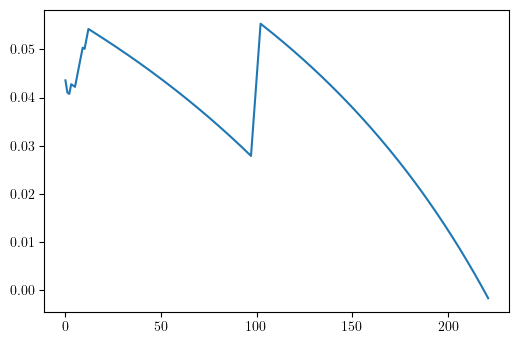

In [30]:
imp.reload(main)

node = 0 # 0, 1, or 2

array = [i[0] for i in data[1][node]]

print(main.correlation_time(array))

c = []
for k in range(len(array)):
    c += [main.time_correlation(array,k)]
plt.plot(c)
plt.show()

---
---
## Correlation time of the average over 10000 realizations
---
---

In [31]:
sim_data =  main.load_data_cd(protocol, data_type, topology, n, p_gen, q_swap,
                    p_swap, p_cons, cutoff, max_links_swapped, qbits_per_channel,
                    N_samples, total_time, randomseed)
avg_vdegs_sim = sim_data['avg_vdegrees']
avg_vneighs_sim = sim_data['avg_vneighs']
std_vdegs_sim = sim_data['std_vdegrees']
std_vneighs_sim = sim_data['std_vneighs']

185.27318283114354


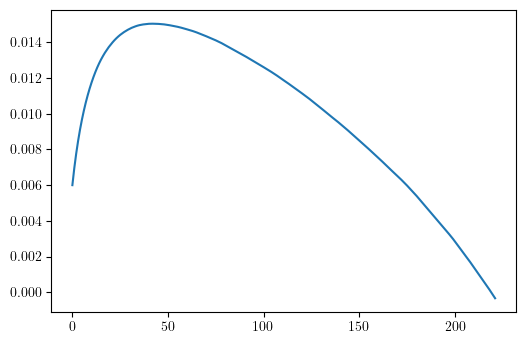

In [34]:
imp.reload(main)

node = 0 # 0, 1, or 2

array = avg_vneighs_sim[2]

print(main.correlation_time(array))

c = []
for k in range(len(array)):
    c += [main.time_correlation(array,k)]
plt.plot(c)
plt.show()